A cellular automaton is a mathematical model that creates patterns automatically according to simple rules. In its simplest, one-dimensional form, it's a row of empty squares, each of which can be occupied or empty. The rules for the model determine how sensitive the occupants of each square are to their immediate left and right neighbours, and whether, after some unspecified time, they survive or die. Sometimes empty squares can miraculously become occupied. Because a square has just two immediate neighbours, there are 8 different cases to consider, ranging from all empty ("□□□" or `000` in binary) to all full ("■■■" or `111`).

The wikipedia has [this nice animation](https://commons.wikimedia.org/wiki/File:One-d-cellular-automate-rule-30.gif){:target="_blank"} showing how the rule produces the next generation of squares.

To explore these simple automata, I started ([^1]) by making a Julia structure:

In [1]:
mutable struct CA
    rule::Int64
    cells::BitArray{1}
    colorstops::Array{Float64, 1}
    ruleset::BitArray{1}
    generation::Int64
    function CA(rule, ncells = 100)
        cells                    = falses(ncells)
        colorstops               = zeros(Float64, ncells)
        ruleset                  = binary_to_array(rule)
        cells[length(cells) ÷ 2] = true
        generation               = 1
        new(rule, cells, colorstops, ruleset, generation)
    end
end

The `cells` array can hold trues or falses. The `colorstops` array is eventually going to hold some color information. The middle cell is seeded with a single starter value.

The `binary_to_array()` function just converts a binary number to a bit array (I suspect there's a quicker way).

In [2]:
function binary_to_array(n)
    a = BitArray{1}()
    for c in 7:-1:0
        k = n >> c
        push!(a, (k & 1 == 1 ? true : false))
    end
    return a
end

binary_to_array (generic function with 1 method)

The `rules()` function takes the values of an individual and its neighbours and applies the rule that determines its state for the next generation:

In [3]:
function rules(ca::CA, a, b, c)
    lng = length(ca.ruleset)
    return ca.ruleset[mod1(lng - (4a + 2b + c), lng)]
    end

rules (generic function with 1 method)

And a `nextgeneration()` function applies the rule to all the cells. I decided to make it wrap around, so that the final cell considers the first cell as one of its neighbours.

In [4]:
function nextgeneration(ca::CA)
    l = length(ca.cells)
    nextgen = falses(l)
    for i in 1:l
        left   = ca.cells[mod1(i - 1, l)]
        me     = ca.cells[mod1(i, l)]
        right  = ca.cells[mod1(i + 1, l)]
        nextgen[i] = rules(ca, left, me, right)
    end
    ca.cells = nextgen
    ca.generation += 1
    return ca
end

nextgeneration (generic function with 1 method)

We'll also teach Julia how to show an automaton in the terminal:

In [5]:
Base.show(io::IO, ::MIME"text/plain", ca::CA) =
    print(io, join([c ? "■" : " " for c in ca.cells]))
# So now we can create a cellular automaton by providing a rule number (using the default of 100 cells):
ca = CA(30)

                                                 ■                                                  

update the automaton like this:

In [6]:
nextgeneration(ca)

                                                ■■■                                                 

and show a historical diagram of its evolution:

In [7]:
for i in 1:10
    display(nextgeneration(ca))
end

                                               ■■  ■                                                

                                              ■■ ■■■■                                               

                                             ■■  ■   ■                                              

                                            ■■ ■■■■ ■■■                                             

                                           ■■  ■    ■  ■                                            

                                          ■■ ■■■■  ■■■■■■                                           

                                         ■■  ■   ■■■     ■                                          

                                        ■■ ■■■■ ■■  ■   ■■■                                         

                                       ■■  ■    ■ ■■■■ ■■  ■                                        

                                      ■■ ■■■■  ■■ ■    ■ ■■■■                                       

### Some graphics

The REPL display is more or less functional, but I want to play with the graphic output, so (you guessed):

In [9]:
#]add Luxor
using Luxor, Colors

┌ Info: Recompiling stale cache file C:\Users\User\.julia\compiled\v1.2\Luxor\HA9ps.ji for Luxor [ae8d54c2-7ccd-5906-9d76-62fc9837b5bc]
└ @ Base loading.jl:1240


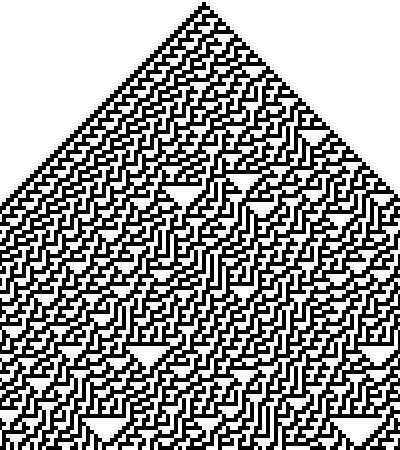

In [10]:
function draw(ca::CA, cellwidth=10)
    lng = length(ca.cells)
    for i in 1:lng
        if ca.cells[i] == true
            pt = Point(-(lng ÷ 2) * cellwidth + i * cellwidth, 0)
            box(pt, cellwidth, cellwidth, :fill)
        end
    end
end

@png begin
    ca = CA(30, 200)
    sidelength = 4
    # start at the top
    translate(boxtopcenter(BoundingBox()) + sidelength)
    for i in 1:200
        draw(ca, sidelength)
        nextgeneration(ca)
        translate(Point(0, sidelength))
    end
    end 400 450 "simple-ca.png"

You can call `nextgeneration()` without displaying the results, of course. This lets you jump into the future history of an automaton at warp speed.

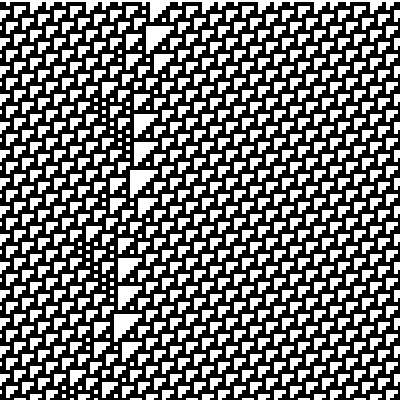

In [11]:
@png begin
    ca = CA(110, 200)
    translate(boxtopcenter(BoundingBox()) + sidelength)
    sidelength = 4
    # into the future
    for _ in 1:200_000
        nextgeneration(ca)
    end
    for _ in 1:195
        draw(ca, sidelength)
        nextgeneration(ca)
        translate(Point(0, sidelength))
    end
    end 400 400 "simple-ca-future.png"

I found that sometimes drawing them from left to right looked better (like videos recorded on phones...?):

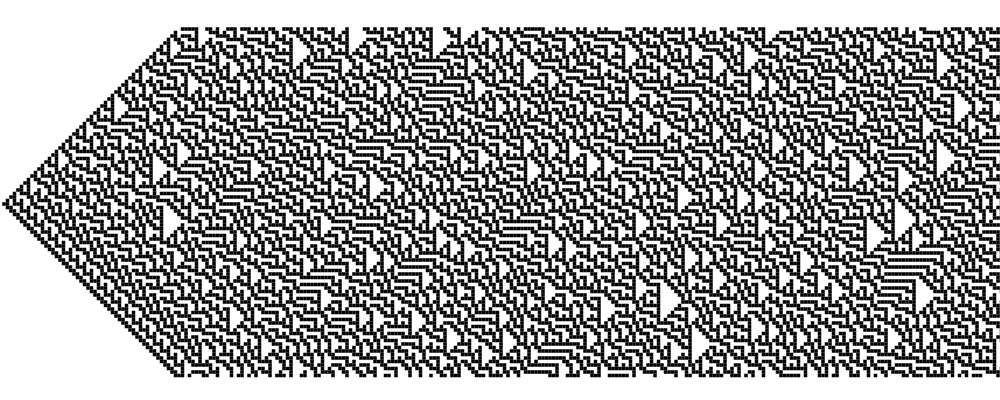

In [11]:
@png begin
    ca = CA(30)
    translate(boxmiddleleft(BoundingBox()) + sidelength)
    rotate(-π/2)
    sidelength = 3.5
    for i in 1:320
        draw(ca, sidelength)
        nextgeneration(ca)
        translate(Point(0, sidelength))
    end
end 1000 400 "simple-landscape-ca.png"

### And now in color

So far I haven't used the color information that's stored.

The `nextgeneration()` function can be updated with instructions about how to modify the color of the next generation, based on the current set of three cells.

In [12]:
function nextgeneration(ca::CA)
    l = length(ca.cells)
    nextgen = falses(l)
    for i in 1:l
        left   = ca.cells[mod1(i - 1, l)]
        me     = ca.cells[mod1(i, l)]
        right  = ca.cells[mod1(i + 1, l)]
        nextgen[i] = rules(ca, left, me, right)
        if me == 1
            ca.colorstops[i] = mod(ca.colorstops[i] + 0.1, 1)
        elseif left == 1 && right == 1
            ca.colorstops[i] = mod(ca.colorstops[i] - 0.1, 1)
        else
            ca.colorstops[i] = 0
        end
    end
    ca.cells = nextgen
    ca.generation += 1
    return ca
end

nextgeneration (generic function with 1 method)

and the `draw()` function can be adapted to make use of the color information. I decided to avoid tackling RGB color value transformations for a first pass, so the single value between 0 and 1 is used to select a color from a color map.

In [13]:
using ColorSchemes

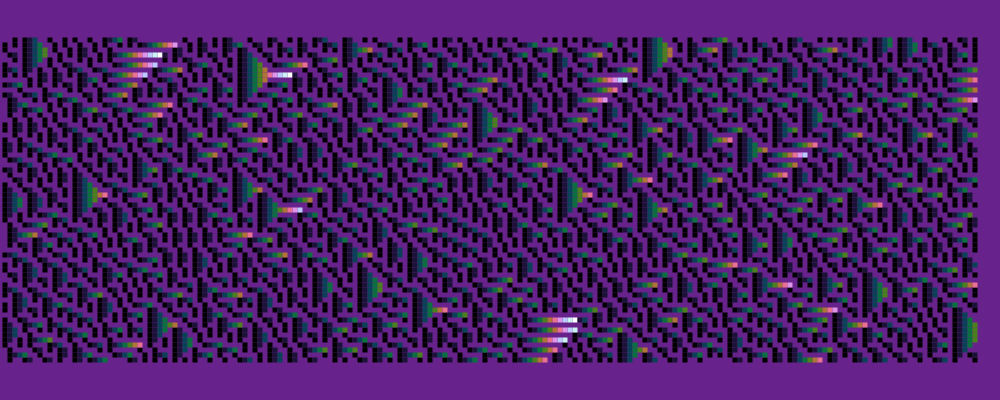

In [14]:
function drawcolor(ca::CA, cellwidth=10;
        scheme=ColorSchemes.leonardo)
    lng = length(ca.cells)
    for i in 1:lng
        if ca.cells[i] == true
            sethue(get(scheme, ca.colorstops[i]))
            pt = Point(-(lng ÷ 2) * cellwidth + (i * cellwidth), 0)
            box(pt, cellwidth, cellwidth, :fill)
        end
    end
end

@svg begin
    background("darkorchid4")
    ca = CA(135, 65)
    # randomize start state
    ca.cells = rand(Bool, length(ca.cells))
    sidelength = 5
    translate(boxmiddleleft(BoundingBox()) + sidelength)
    rotate(-π/2)
    for i in 1:195
        drawcolor(ca, sidelength, scheme=ColorSchemes.cubehelix)
        nextgeneration(ca)
        translate(Point(0, sidelength))
    end
end 1000 400 "images/automata/simple-color-ca.svg"

This could lead to hours of entertainment (depending on your definition of fun, of course). I uploaded a few experiments that didn't turn out too badly [on Flickr](https://www.flickr.com/photos/153311384@N03/){:target="_blank"}. The current rules show a kind of literal winning streak, as a cell that remains occupied for many generations ends up being brightly illuminated.

I think these images look quite good when scaled up. It only takes about a second to draw these, but would take much longer to stick them on the wall:

The rules for specifying a change in color could do with some kind of systematic definition, perhaps, such that, say, "rule C81" means "increase colorstop by amount if previous parent is 1, decrease it if previous uncle-aunt is 1", and so on. Then you could pass a set of color rules to the drawing function. (*uncle-aunt*? I couldn't find a word for something that is either an uncle or an aunt, but not a parent...)

Instead of drawing simple squares, it's possible to draw other shapes. I'm quite fond of the squircle — you can change the `rt` parameter to get different shapes:

### Getting around to it

It occurred to me that you could take a rectangular array and wrap it into a circle.

In [23]:
function drawsector(ca::CA, cellwidth=10;
        scheme=ColorSchemes.leonardo,
        centralradius = 10)
    lng = length(ca.cells)
    width = lng * cellwidth
    angulargap = 2π/lng
    for i in 1:lng
        sethue(get(scheme, ca.colorstops[i]))
        innerradius = centralradius
        outerradius = centralradius + cellwidth
        startang    = rescale(i, 1, lng, 0, 2π)
        endang      = startang + angulargap
        if ca.cells[i] == true
            sector(O, innerradius, outerradius, startang, endang, :fillstroke) # radiuses*4
        end
    end
end

function drawrule(rulenumber, pos)
    @layer begin
        translate(pos)
        sethue("black")
        text(string(rulenumber), halign=:center, valign=:middle)
        rotate(-π/2)
        ca = CA(rulenumber, 50)
        # randomize start state
        # ca.cells = rand(Bool, length(ca.cells))
        sidelength = 2
        setline(0.0)
        for n in 5:sidelength:30
            drawsector(ca, sidelength,
            scheme=ColorSchemes.afmhot,
            centralradius = n)
            nextgeneration(ca)
        end
    end
end

drawrule (generic function with 1 method)

This shows all the rules in this circular form.

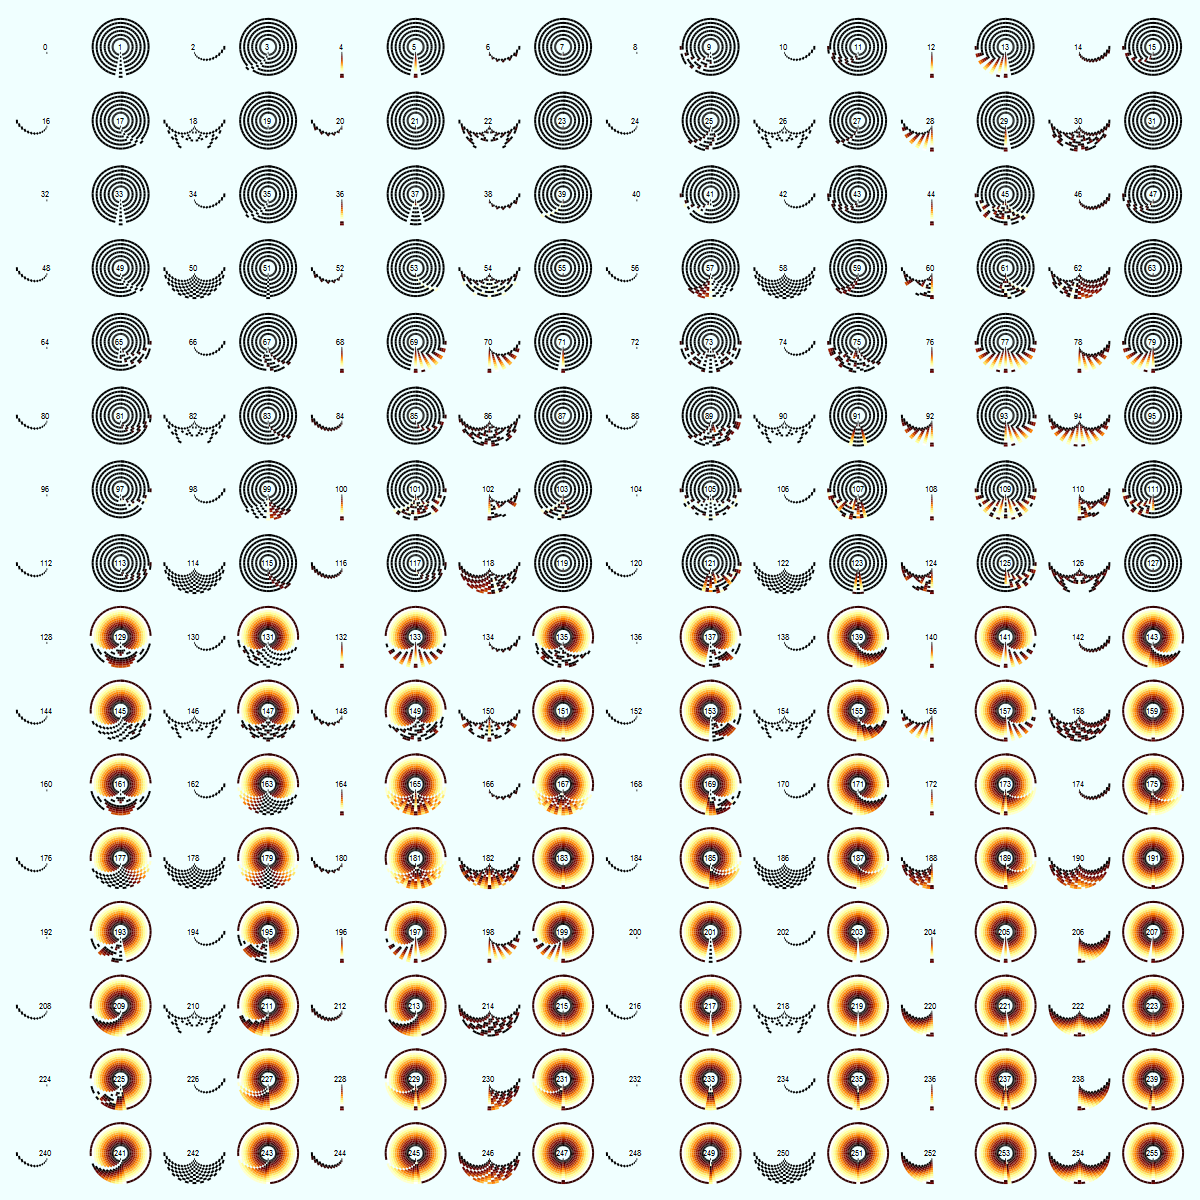

In [74]:
let
    # best in SVG or PDF, but PNG is faster
    Drawing(1200, 1200, "color-sector-assembly.png")
    origin()
    background("azure")
    fontsize(8)
    for (pos, n) in Tiler(1200, 1200, 16, 16)
        drawrule(n-1, pos)
    end
    finish()
    preview()
end

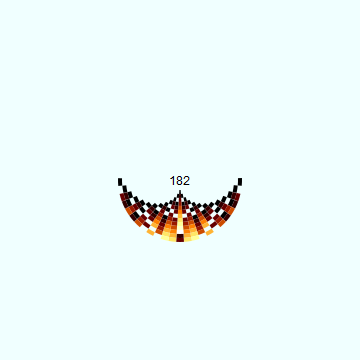

In [24]:
let
    # best in SVG or PDF, but PNG is faster
    Drawing(360, 360, "color-sector-assembly1.png")
    origin()
    background("azure")
    fontsize(12)
    drawrule(182, Point(0, 0))
    finish()
    preview()
end

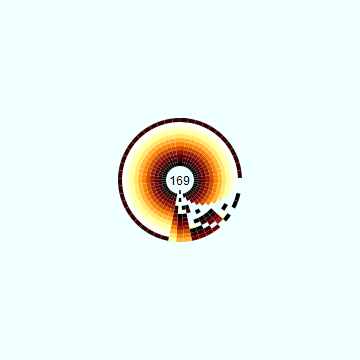

In [25]:
let
    # best in SVG or PDF, but PNG is faster
    Drawing(360, 360, "color-sector-assembly1.png")
    origin()
    background("azure")
    fontsize(12)
    drawrule(169, Point(0, 0))
    finish()
    preview()
end

https://juliagraphics.github.io/ColorSchemes.jl/stable/basics/

(Again, this image is quite demanding for SVG and can take a while to load, even though it doesn't take long to generate.)

After playing with this idea, I thought it would make some nice jewellery:

This is rule 150. I mapped the array to a semicircle and drew it twice.